Using client is super easy. The following steps are best run in Jupyter notebook or [Google Colab](https://colab.research.google.com/github/jina-ai/dalle-flow/blob/main/client.ipynb).  

The only dependency you will need are [DocArray](https://github.com/jina-ai/docarray) and [Jina](https://github.com/jina-ai/jina), as DocArray is already included in Jina you only need to install `jina`.

> On Google Colab, you will be asked to restart the kernel. Go ahead and restart.

In [2]:
!pip install jina

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 226 kB 31.6 MB/s 
     |████████████████████████████████| 1.0 MB 46.5 MB/s 
     |████████████████████████████████| 638 kB 56.0 MB/s 
     |████████████████████████████████| 112 kB 44.9 MB/s 
     |████████████████████████████████| 147 kB 55.8 MB/s 
     |████████████████████████████████| 57 kB 5.4 MB/s 
     |████████████████████████████████| 54 kB 3.1 MB/s 
     |████████████████████████████████| 59 kB 7.0 MB/s 
     |████████████████████████████████| 3.8 MB 40.2 MB/s 
     |████████████████████████████████| 4.1 MB 49.3 MB/s 
     |████████████████████████████████| 235 kB 56.3 MB/s 
     |████████████████████████████████| 1.2 MB 68.5 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 80 kB 9.8 MB/s 
     |████████████████████████████████| 51 kB 6.9 MB/s 
     |████████████████████████████████| 139

We have provided a demo server for you to play:

In [3]:
server_url = 'grpcs://dalle-flow.dev.jina.ai'

## (optional) Check how many pending requests on the server

Our demo server can be very very crowded, hence when running the code below it may take unexpected long time. 

Fortunately, [Jina](https://github.com/jina-ai/jina) has integrated [Prometheus](https://prometheus.io/) which allows user to check the status of the server. In particular, in this case we are interested in the number queuing/pending requests, which gives us an idea how crowd is the server.

In [4]:
!curl -s http://dalle-flow-monitoring.dev.jina.ai/gateway  | grep 'jina_number_of_pending_requests{runtime_name="gateway/GRPCGatewayRuntime"}' | cut -d' ' -f 2

141.0


### Step 1: Generate via DALL·E Mega

Now let's define the prompt:

In [5]:
prompt = 'an oil painting of a biopunk with a robotic eye dancing with a Gorilla'

Do you need some hints and suggestions on the prompt? Check out those tricks:
 - [A Guide to Writing Prompts for Text-to-image AI](https://docs.google.com/document/d/17VPu3U2qXthOpt2zWczFvf-AH6z37hxUbvEe1rJTsEc/edit?usp=sharing)
 - [CLIP Templates](https://docs.google.com/document/d/1j2IAumYz4iZopOTAAOcCUKbFXP0jHK8mRgD4NLFKkaw/edit?usp=sharing)

Let's submit it to the server and visualize the results:

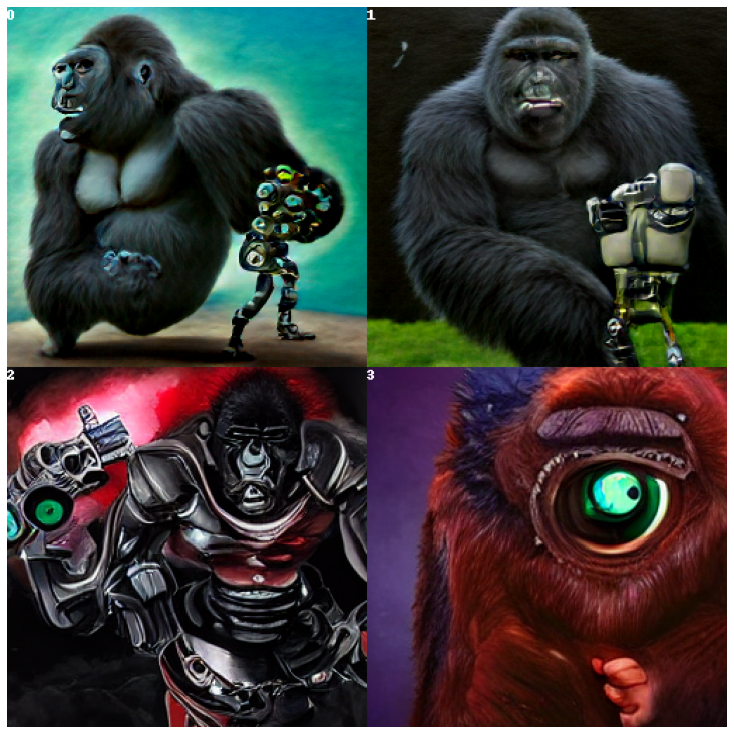

CPU times: user 1.39 s, sys: 163 ms, total: 1.55 s
Wall time: 40.8 s


In [6]:
%%time

from docarray import Document

doc = Document(text=prompt).post(server_url, parameters={'num_images': 2})
da = doc.matches

da.plot_image_sprites(fig_size=(10,10), show_index=True)

Here we generate 4 candidates, 2 from DALLE-mega and 2 from GLID3 XL, this is as defined in `num_images`, which takes about ~2 minutes. You can use a smaller value if it is too long for you. The results are sorted by [CLIP-as-service](https://github.com/jina-ai/clip-as-service), with index-`0` as the best candidate judged by CLIP. 

> You could generate up to 8 images per pathway via `num_images`, resulting 16 candidate images in total. But it will be much slower.

### Step 2: Select and refinement via GLID3 XL

Of course, you may think differently. Notice the number in the top-left corner? Select the one you like the most and get a better view:

In [8]:
fav_id = 1

fav = da[fav_id]
fav.embedding = doc.embedding

fav.display()

Now let's submit the selected candidates to the server for diffusion.

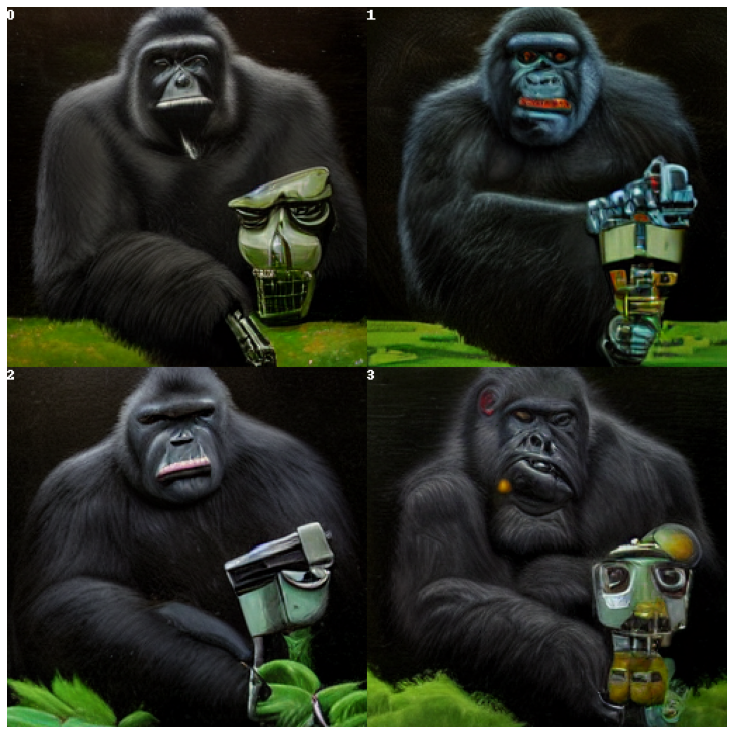

CPU times: user 896 ms, sys: 32.5 ms, total: 929 ms
Wall time: 21.1 s


In [9]:
%%time

diffused = fav.post(f'{server_url}', parameters={'skip_rate': 0.6, 'num_images': 4}, target_executor='diffusion').matches

diffused.plot_image_sprites(fig_size=(10,10), show_index=True)

This will give 4 images based on the given image. You may allow the model to improvise more by giving `skip_rate` a near-zero value, or a near-one value to force its closeness to the given image. The whole procedure takes about ~1 minutes.

> You could generate upto 8 images via `num_images`. But it will be slower.

### Step 3: Select and upscale via SwinIR

Select the image you like the most, and give it a closer look:


In [12]:
dfav_id = 1

fav = diffused[dfav_id]

fav.display()

If not satisfied, you can rerun the last cell in step 2 with this new `fav`.

Finally, submit to the server for the last step: upscaling to 1024 x 1024px.

> This step should be much faster (~10s) as the Flow is designed in unblocked manner.

In [11]:
%%time

fav = fav.post(f'{server_url}/upscale')
fav.display()

Output hidden; open in https://colab.research.google.com to view.

> 💁‍♂️ On Google colab this image may render exactly the same size as before. But it is in 1024x1024 already. Right click on the image and copy/save it. You will see.

That's it! It is _the one_.


Btw, [DocArray is a powerful and easy-to-use data structure for unstructured data](https://github.com/jina-ai/docarray), that makes all of these possible. It is super productive for data scientists who work in cross-/multi-modal domain. To learn more about DocArray, [please check out the docs](https://docarray.jina.ai).